# ACTS-MU10-PT1000-T50

In [1]:
!nvidia-smi

Fri Nov 10 14:49:01 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 27%   28C    P8     9W / 180W |     10MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:05:00.0 Off |                  N/A |
| 27%   30C    P8     9W / 180W |     10MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [ ]:
import os
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:04:00.0)


### Load in the data.

In [3]:
%%time
modelpath = "data/models/ACTS-MU10-PT1000-T50.h5"
filepath  = "data/sets/ACTS-MU10-PT1000-T50-PREPARED.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del frame
    del events

Train is list of 52325 events.
Test is list of 13082 events.
Train takes up 418664 bytes.
Test takes up 104720 bytes.
CPU times: user 40.2 s, sys: 1.83 s, total: 42 s
Wall time: 42 s


In [4]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [ ]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

In [ ]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

### Show an example of the data.

Train 47312
Number of Hits: 65
Number of Tracks: 21


<IPython.core.display.Javascript object>


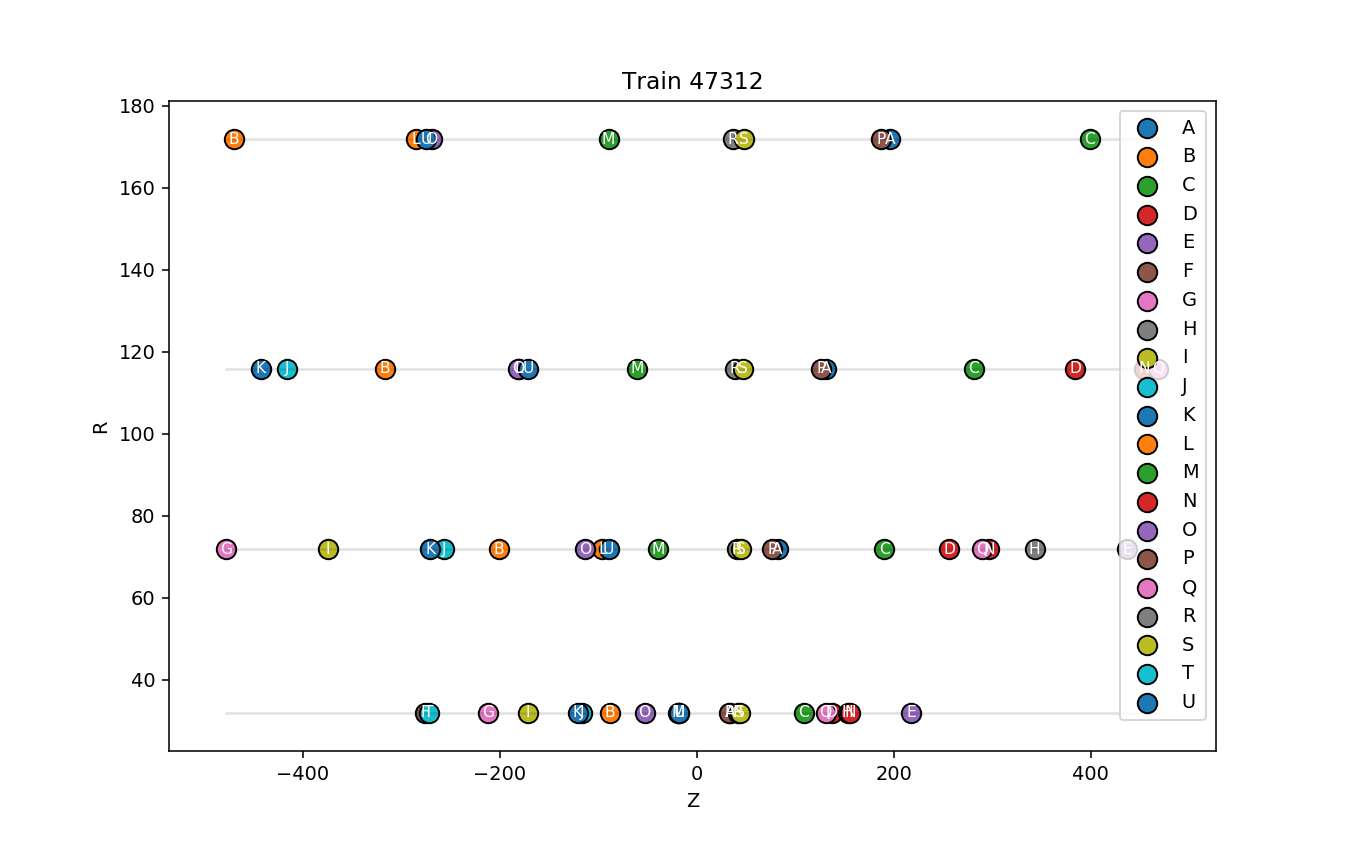

<IPython.core.display.Javascript object>


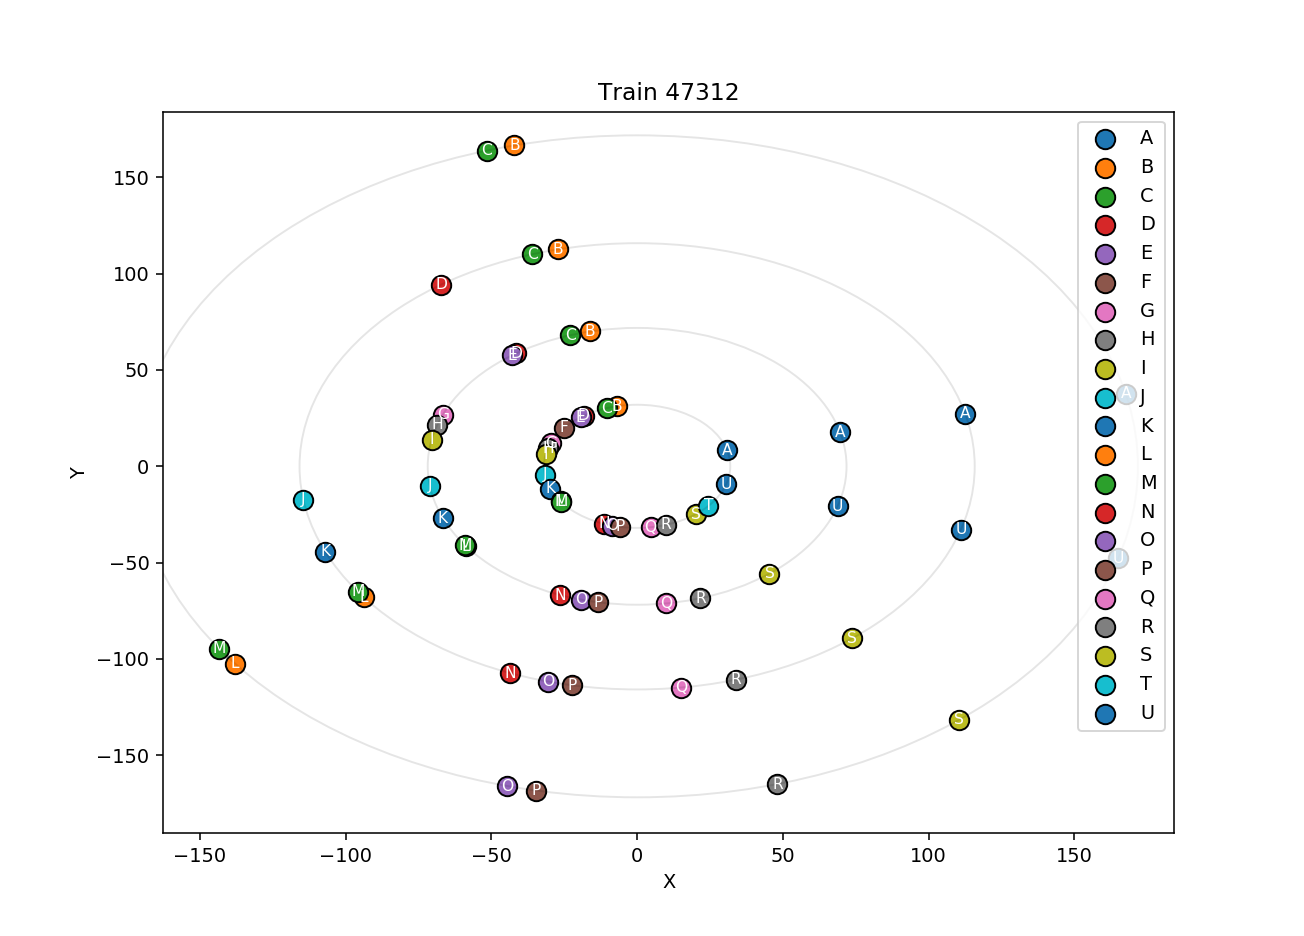

In [6]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [7]:
visuals.display(train[n], order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,[,\,],^,_,`,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,padding
0,0.221038,171.809967,196.2340,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.237500,115.818695,131.5130,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.249983,71.842967,81.9843,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.261567,31.959895,34.1844,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,1.789335,31.959895,-88.3324,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,1.797770,71.842967,-200.8930,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,1.806708,115.818695,-316.0970,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,1.818278,171.809967,-469.7660,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,1.875212,171.809967,398.9730,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,1.886536,115.818695,281.1310,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [5]:
input_shape  = (200, 3)
n_categories = 50 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.0001)
histories    = []

In [6]:
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

### Fit the model.

In [10]:
%%time
# Total Epochs: (21 + 28 + 3 + 4) = 56
epochs     = 128
batch_size = 50
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=5, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)]))

Epoch 1/128
1046/1046 [==============================] - 1085s - loss: 0.0759 - acc: 0.9826 - val_loss: 0.0466 - val_acc: 0.9893
Epoch 2/128
1046/1046 [==============================] - 1060s - loss: 0.0819 - acc: 0.9813 - val_loss: 0.0471 - val_acc: 0.9892
Epoch 3/128
1046/1046 [==============================] - 1064s - loss: 0.0737 - acc: 0.9829 - val_loss: 0.0470 - val_acc: 0.9894
Epoch 4/128
1045/1046 [============================>.] - ETA: 0s - loss: 0.0708 - acc: 0.9835
Epoch 00003: reducing learning rate to 0.00010000000474974513.
1046/1046 [==============================] - 1065s - loss: 0.0707 - acc: 0.9835 - val_loss: 0.0469 - val_acc: 0.9891
Epoch 5/128
1046/1046 [==============================] - 1069s - loss: 0.0744 - acc: 0.9828 - val_loss: 0.0458 - val_acc: 0.9893
Epoch 6/128
1046/1046 [==============================] - 2910s - loss: 0.0687 - acc: 0.9840 - val_loss: 0.0453 - val_acc: 0.9893
Epoch 7/128
1046/1046 [==============================] - 2580s - loss: 0.0658 - a

KeyboardInterrupt: 

### Display information about the model after fitting it.

In [7]:
%%time
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 97.61209183736096%
Percent of tracks assigned correctly: 96.1421179600487%
Percent of events with the correct number of tracks: 95.26830759822657%
CPU times: user 5min 1s, sys: 504 ms, total: 5min 1s
Wall time: 5min 1s


### Display how one of the model's predictions looks.

In [8]:
%matplotlib notebook

Percent of hits assigned correctly: 98.14814814814815%
Percent of tracks assigned correctly: 94.44444444444444%


<IPython.core.display.Javascript object>


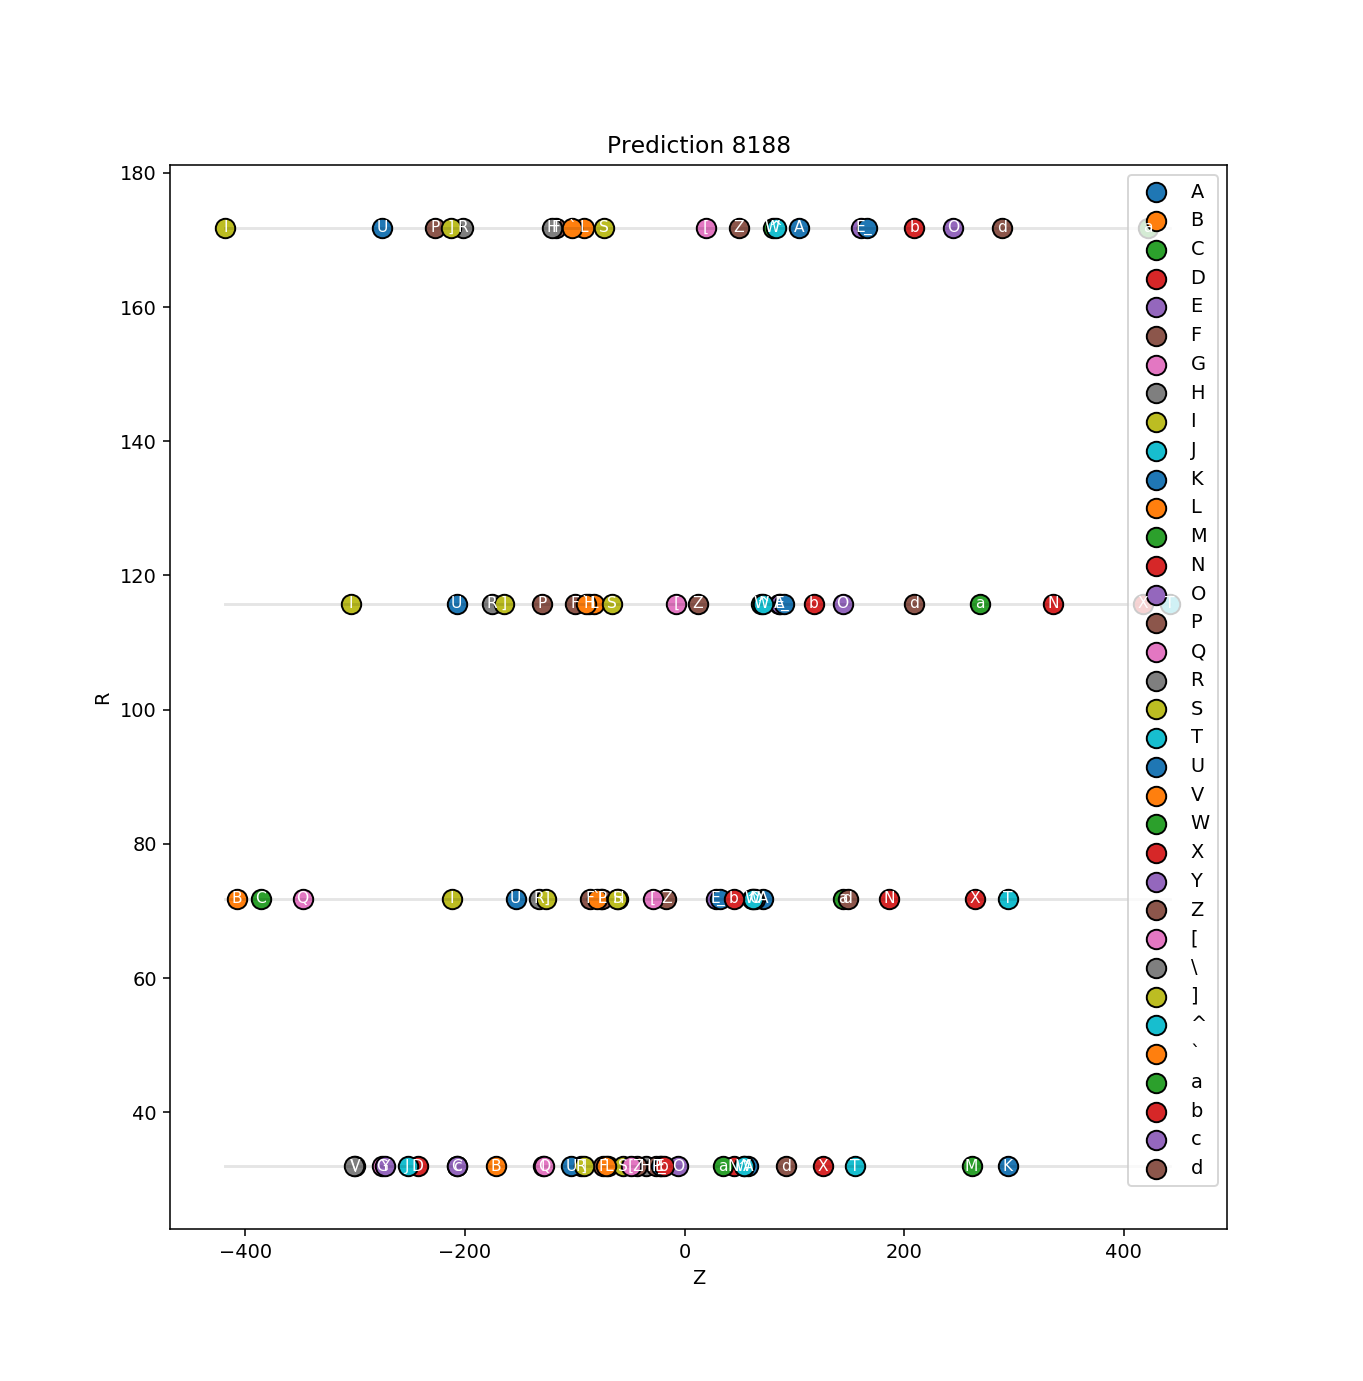

<IPython.core.display.Javascript object>


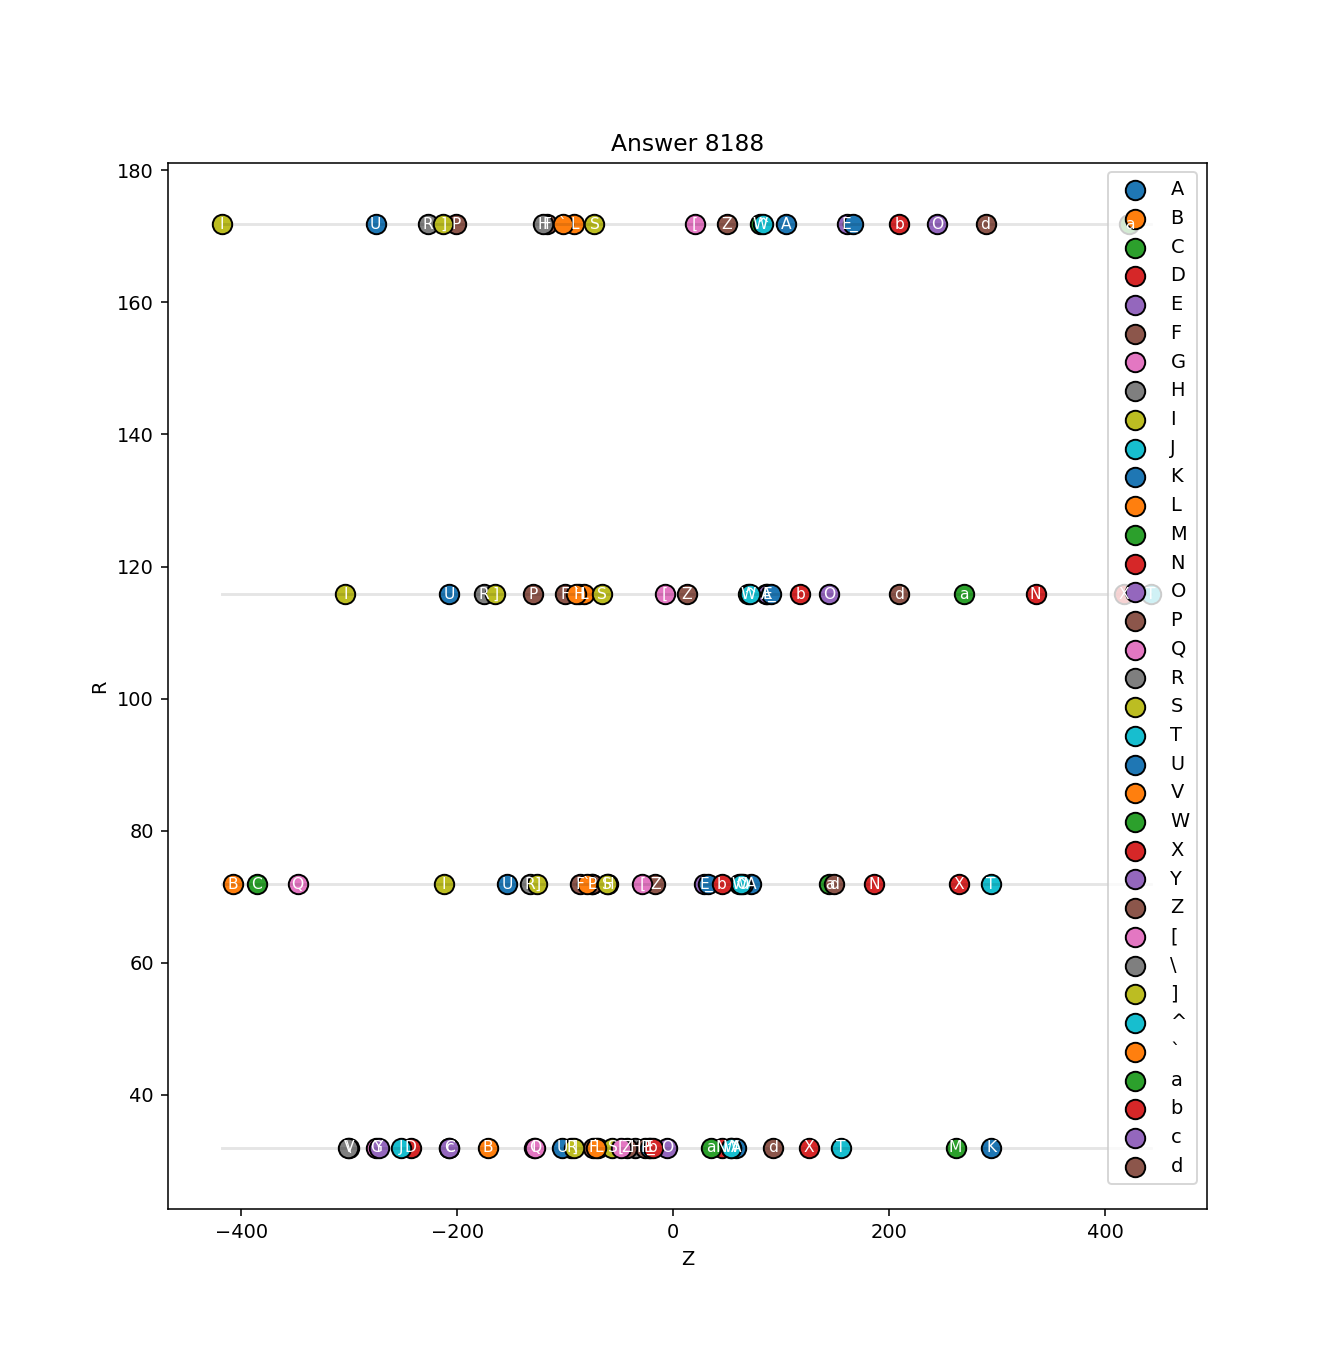

<IPython.core.display.Javascript object>


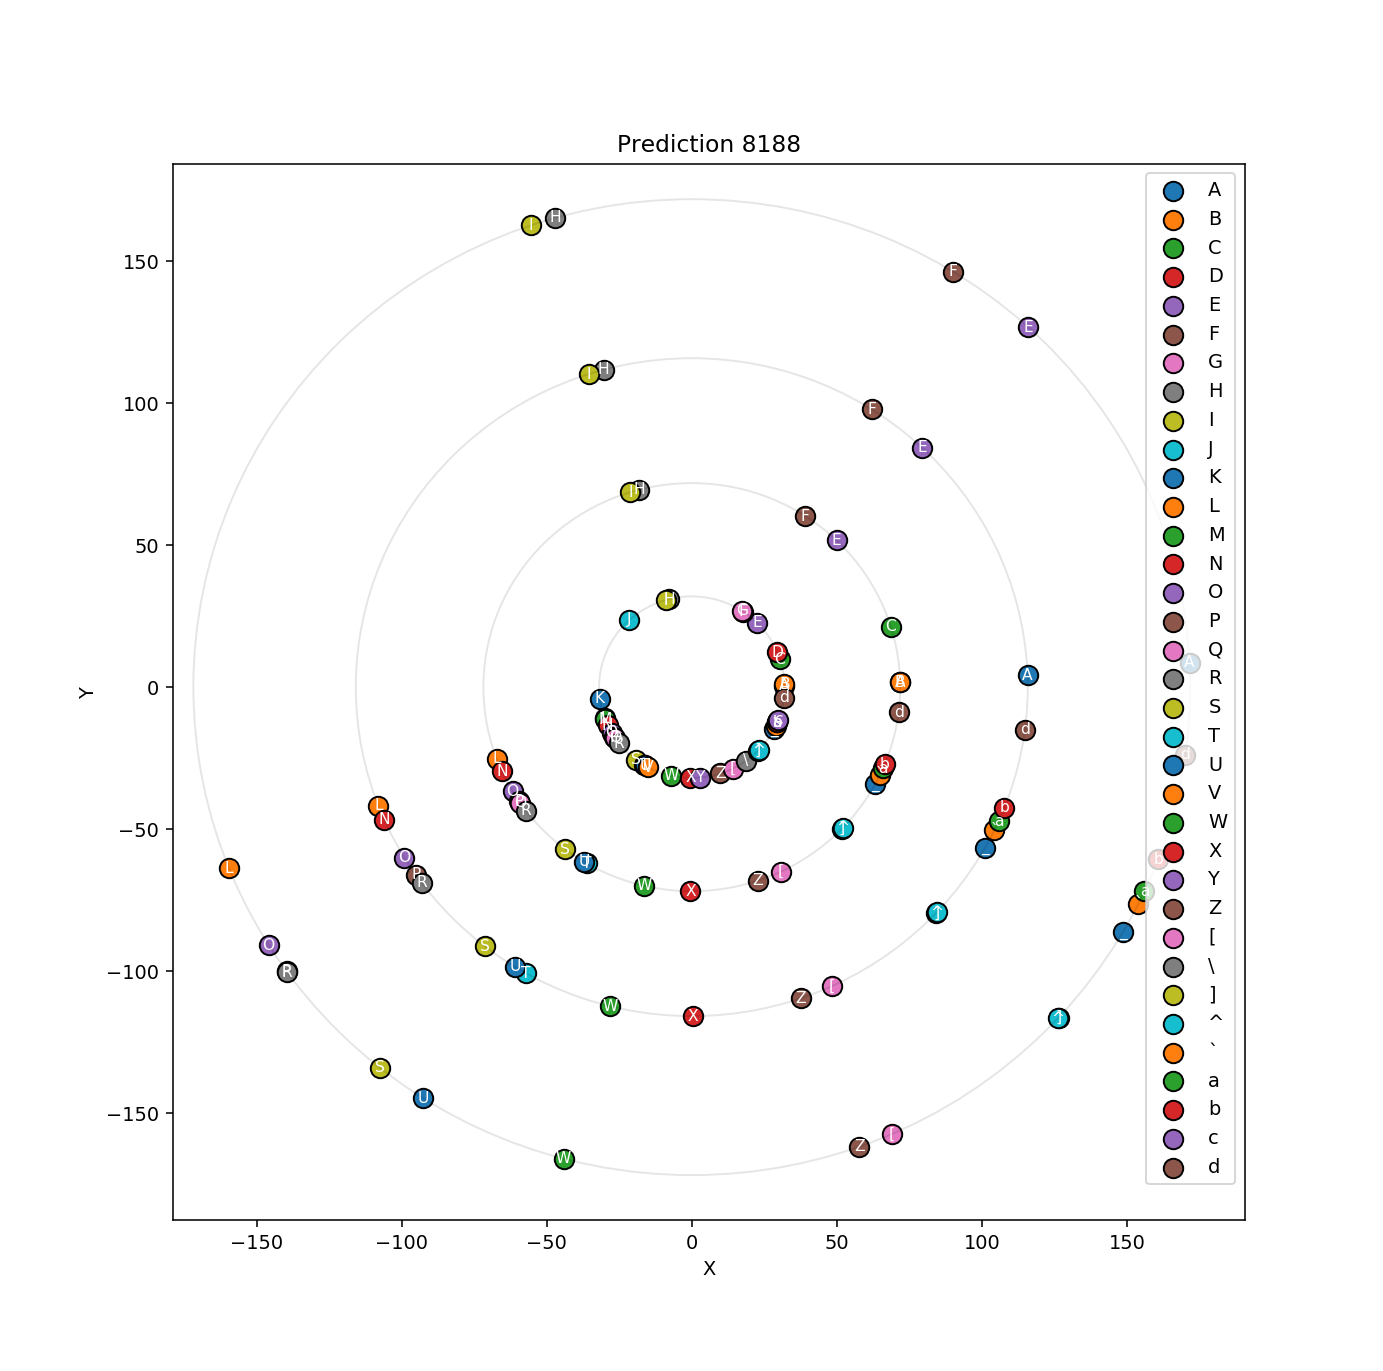

<IPython.core.display.Javascript object>


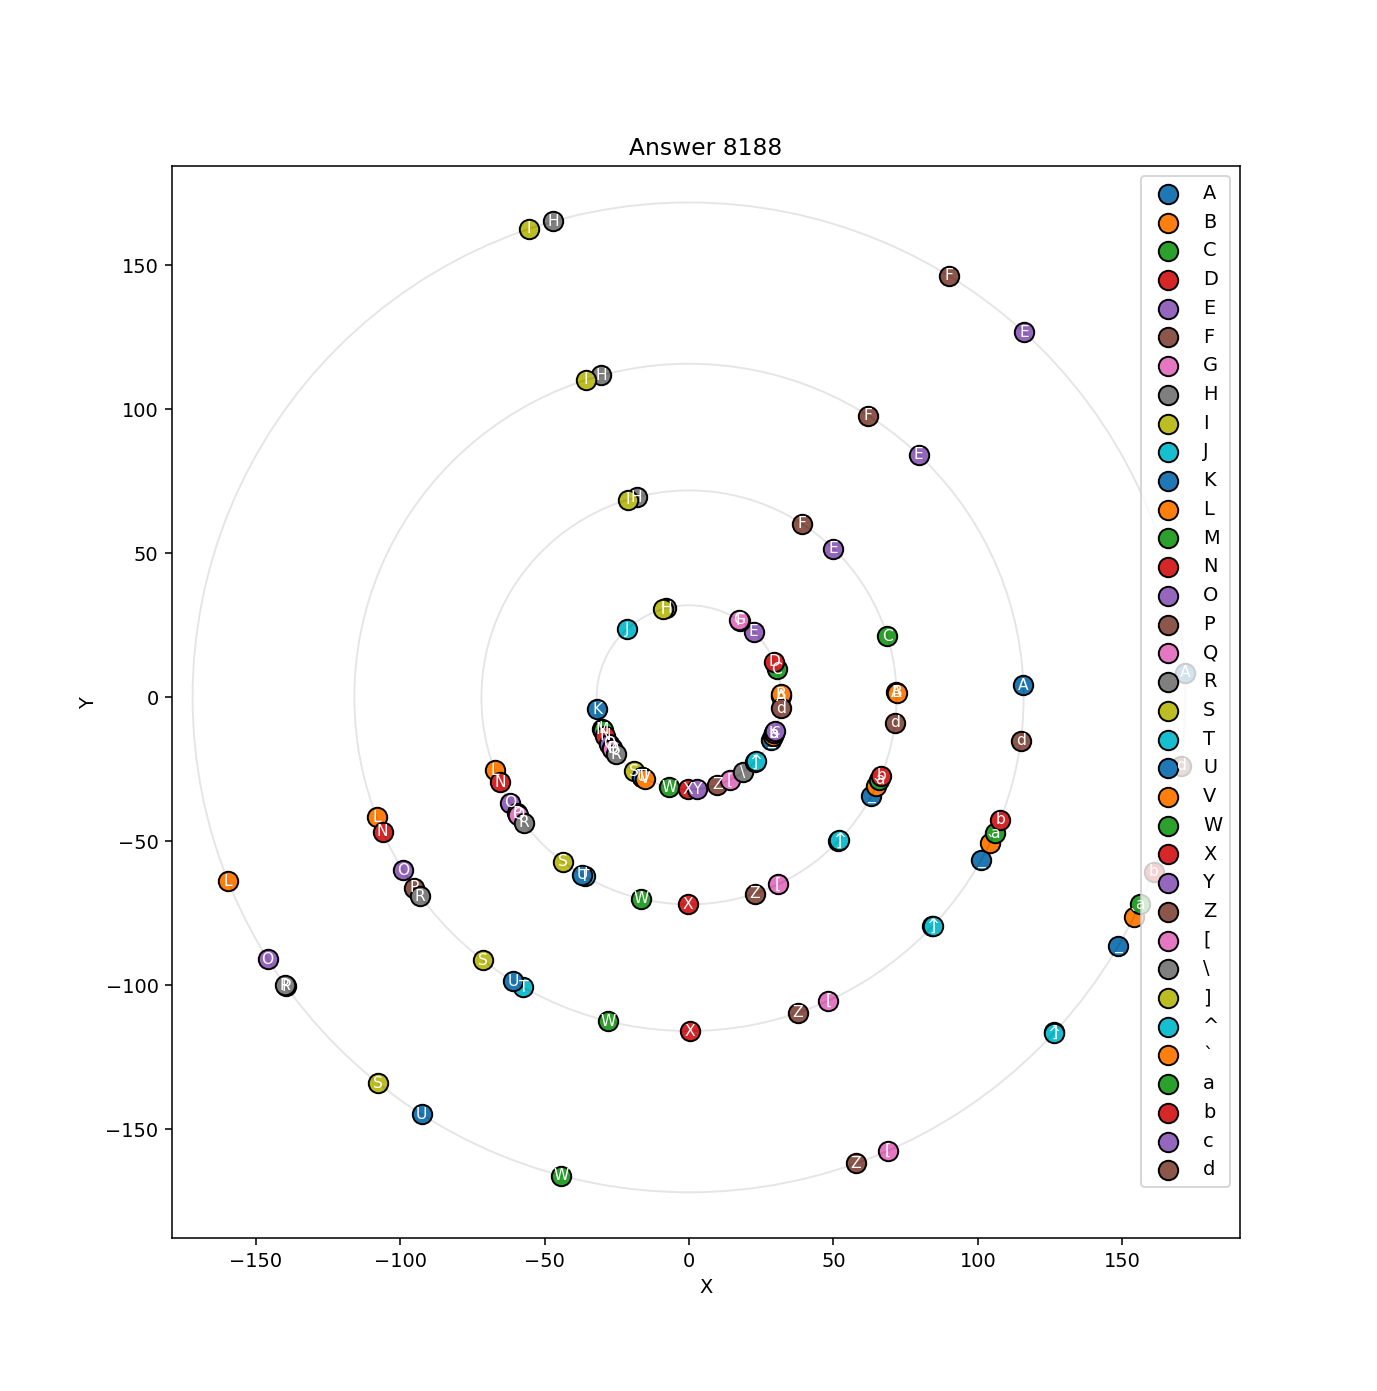

In [20]:
n  = 8188 # np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

In [23]:
# Prediction in single quotes, actual classification in brackets.
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,[,\,],^,_,`,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,padding
0,0.013658,31.959895,58.13010,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.022937,71.842967,-407.84200,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.024861,71.842967,71.80110,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.033477,31.959895,-171.79200,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.035982,115.818695,86.03290,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,0.049919,171.809967,104.15600,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,0.300129,71.842967,-385.59700,,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0.312078,31.959895,-207.37200,,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,0.394951,31.959895,-243.00300,,,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,0.791674,31.959895,-22.62810,,,,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


<IPython.core.display.Javascript object>


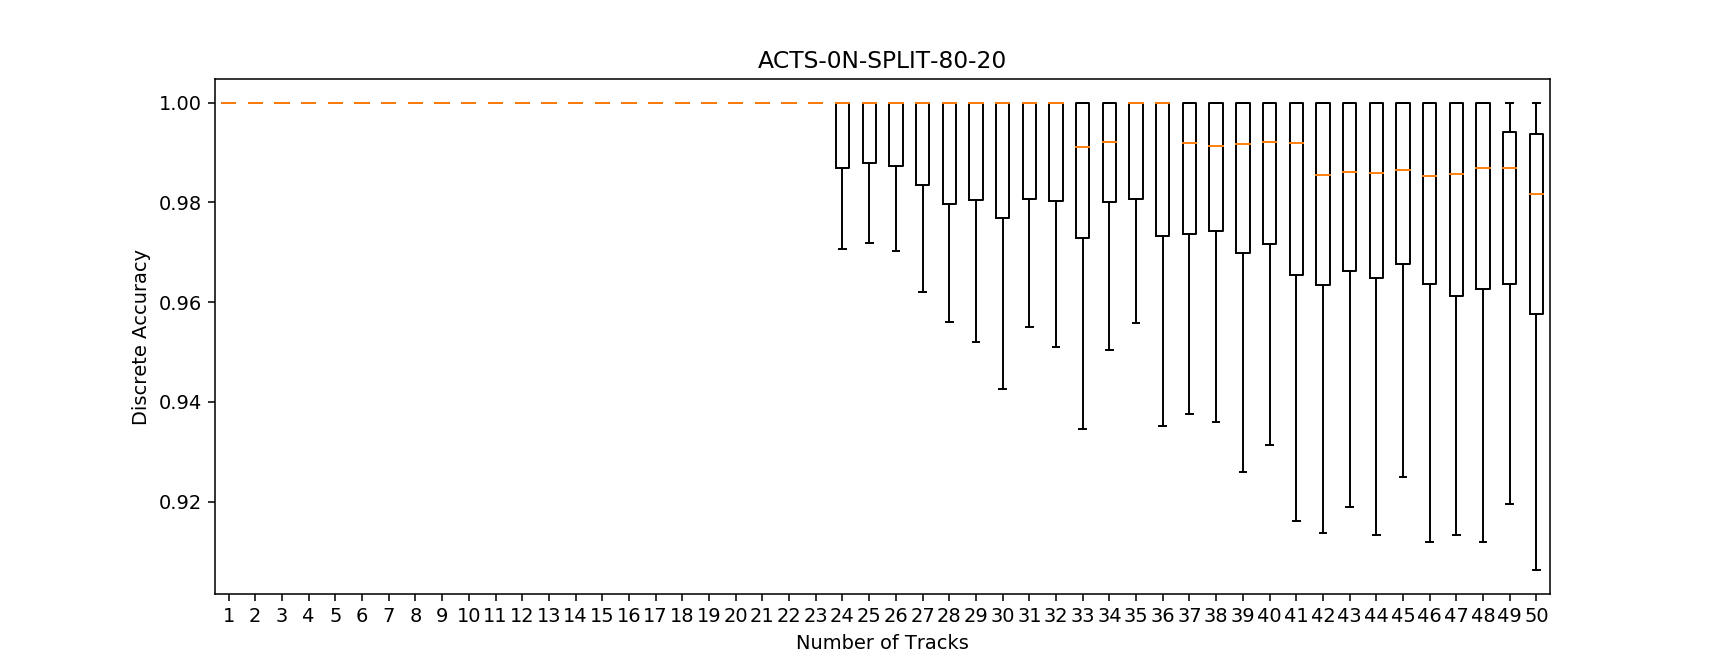

CPU times: user 1min 44s, sys: 28 ms, total: 1min 44s
Wall time: 1min 44s


In [11]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

<IPython.core.display.Javascript object>


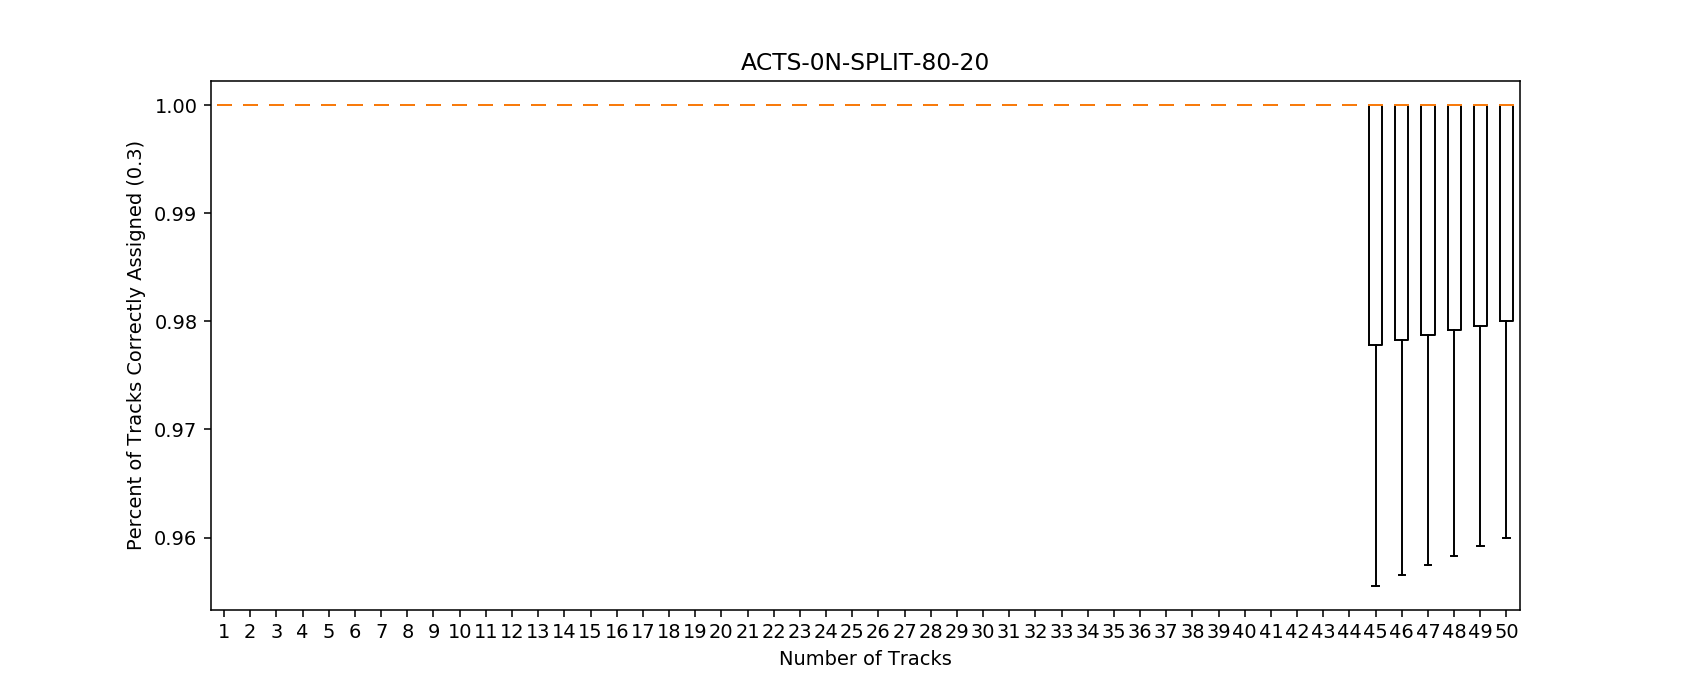

<IPython.core.display.Javascript object>


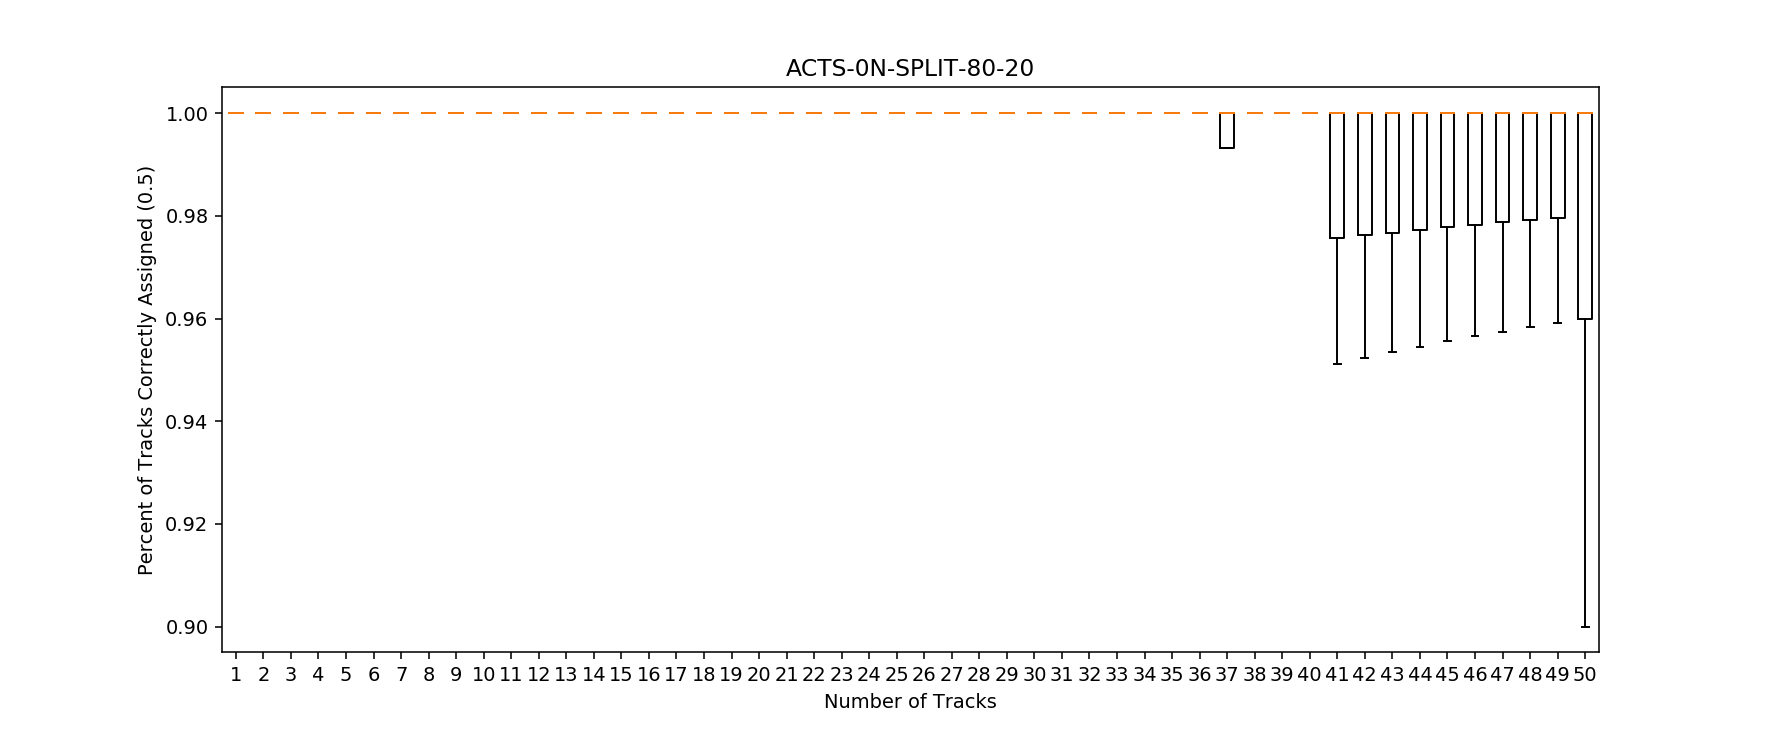

<IPython.core.display.Javascript object>


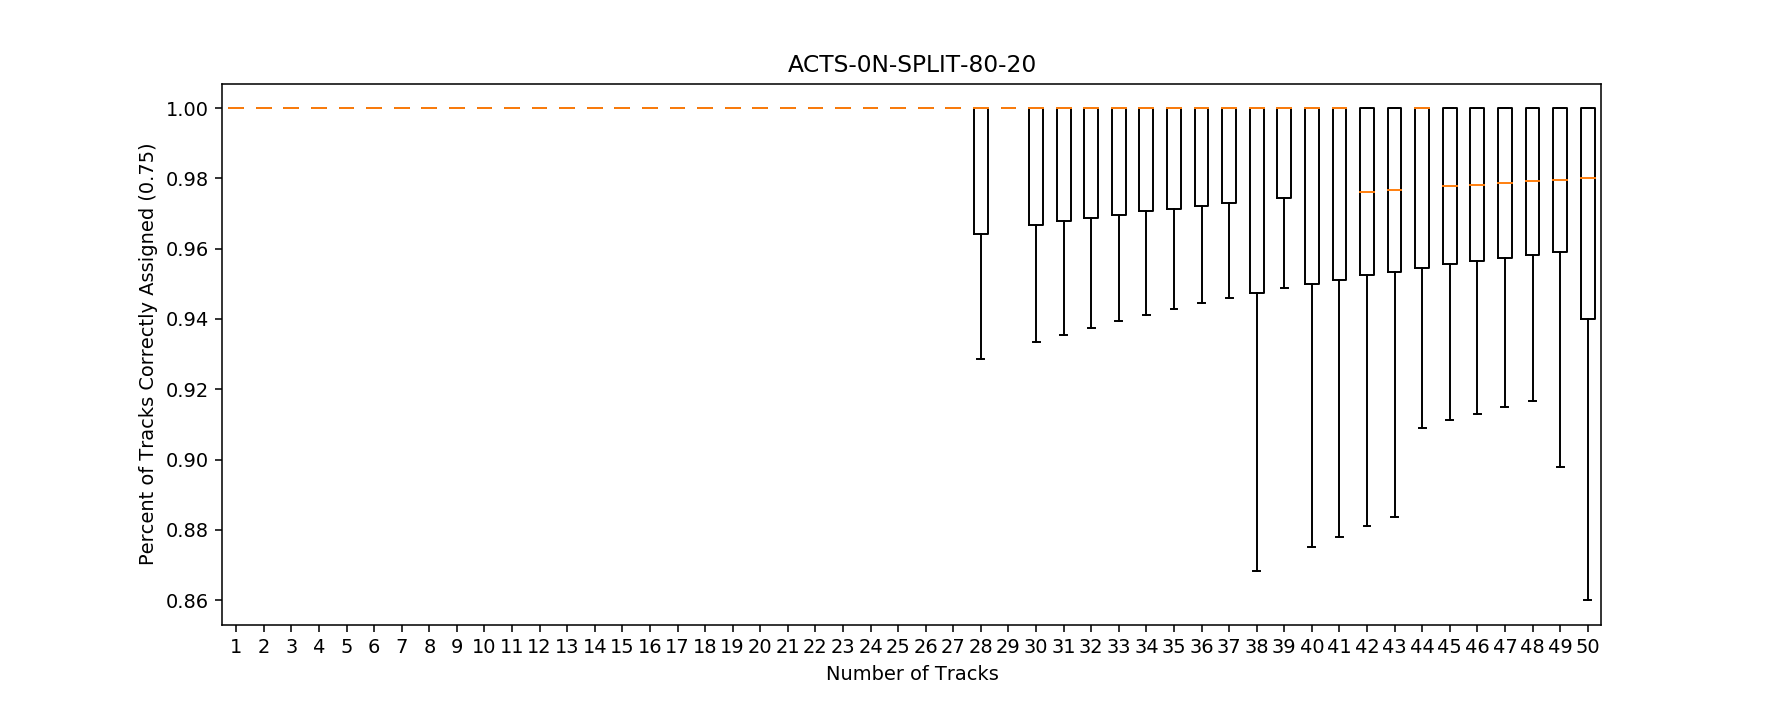

<IPython.core.display.Javascript object>


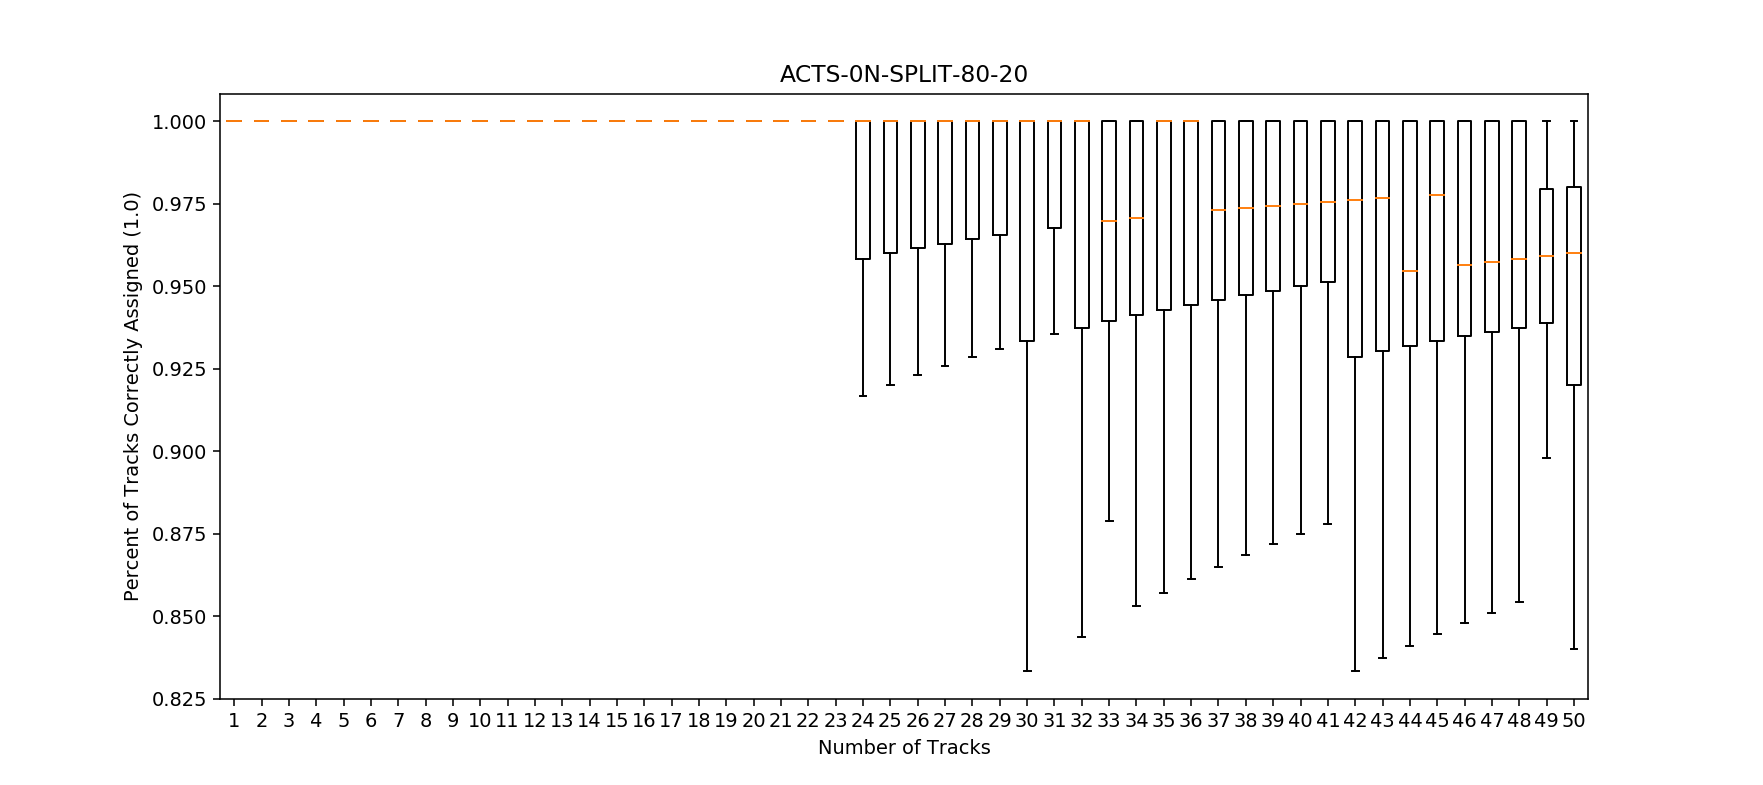

CPU times: user 10min 6s, sys: 284 ms, total: 10min 6s
Wall time: 10min 6s


In [12]:
%%time
for percent in [0.3, 0.5, 0.75, 1.0]:
    c_tracks = [metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order, percent=percent)
                for n in range(len(guesses))]
    boxes = [[] for _ in r]
    for i in range(len(c_tracks)):
        index = metrics.number_of_tracks(test[i]) - 1
        boxes[index].append(c_tracks[i])
    visuals.boxplot(
        boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks",
        "Percent of Tracks Correctly Assigned ({})".format(percent), xticks=list(r))

<IPython.core.display.Javascript object>


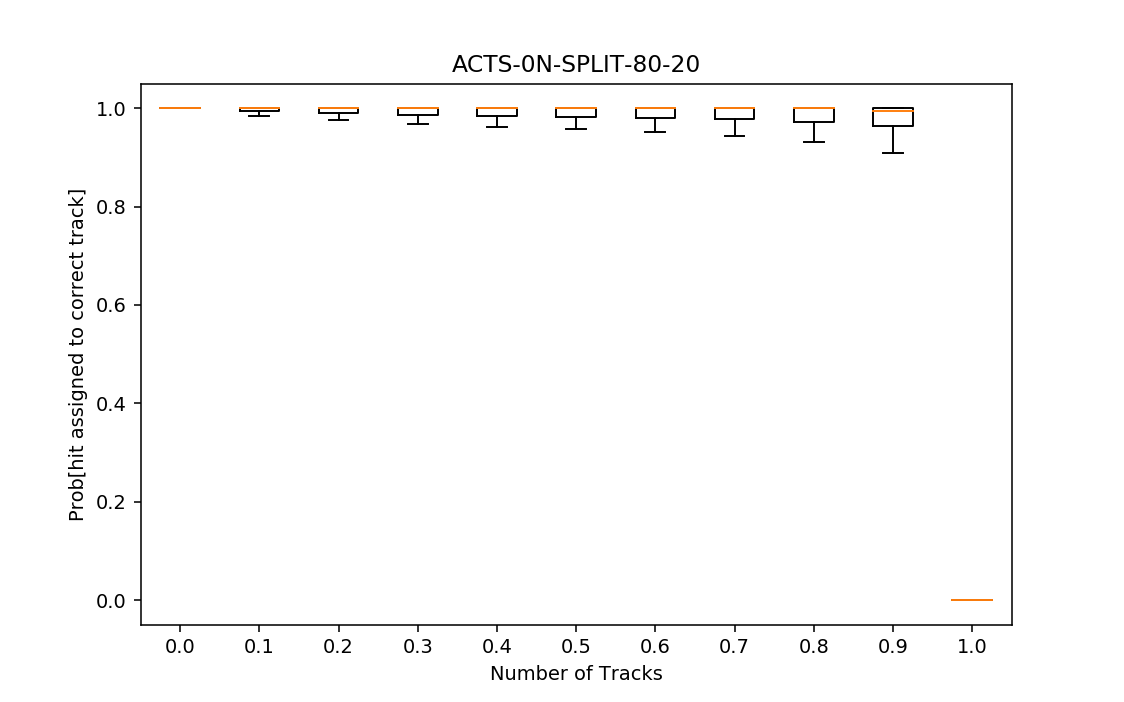

<IPython.core.display.Javascript object>


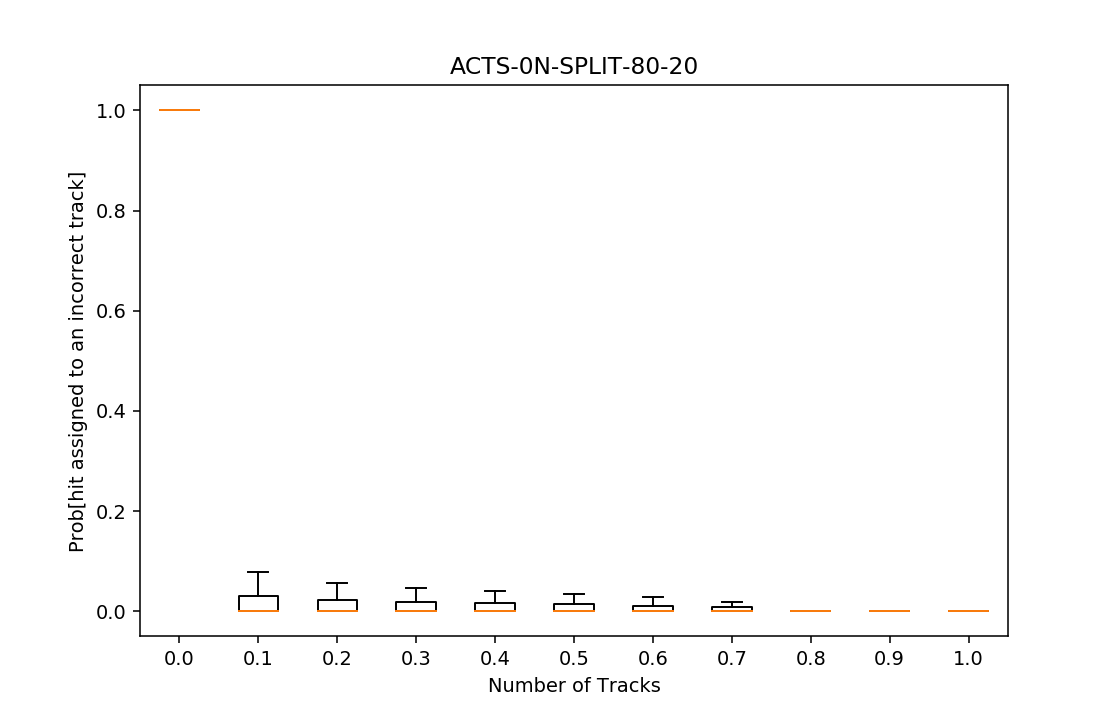

<IPython.core.display.Javascript object>


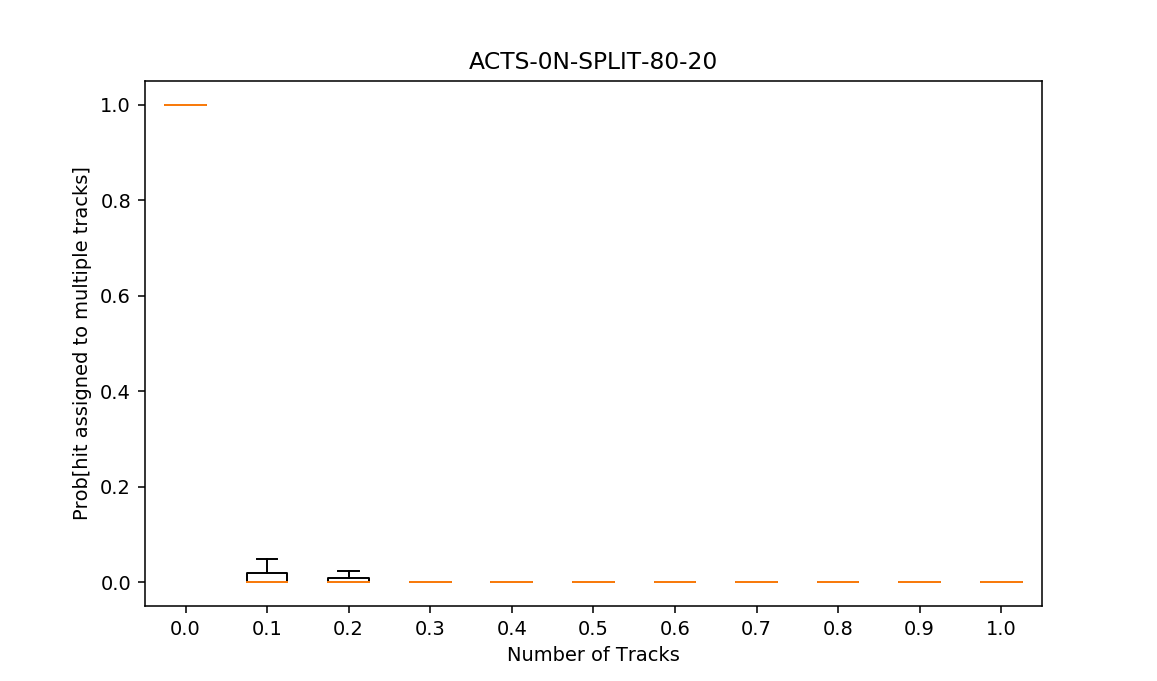

<IPython.core.display.Javascript object>


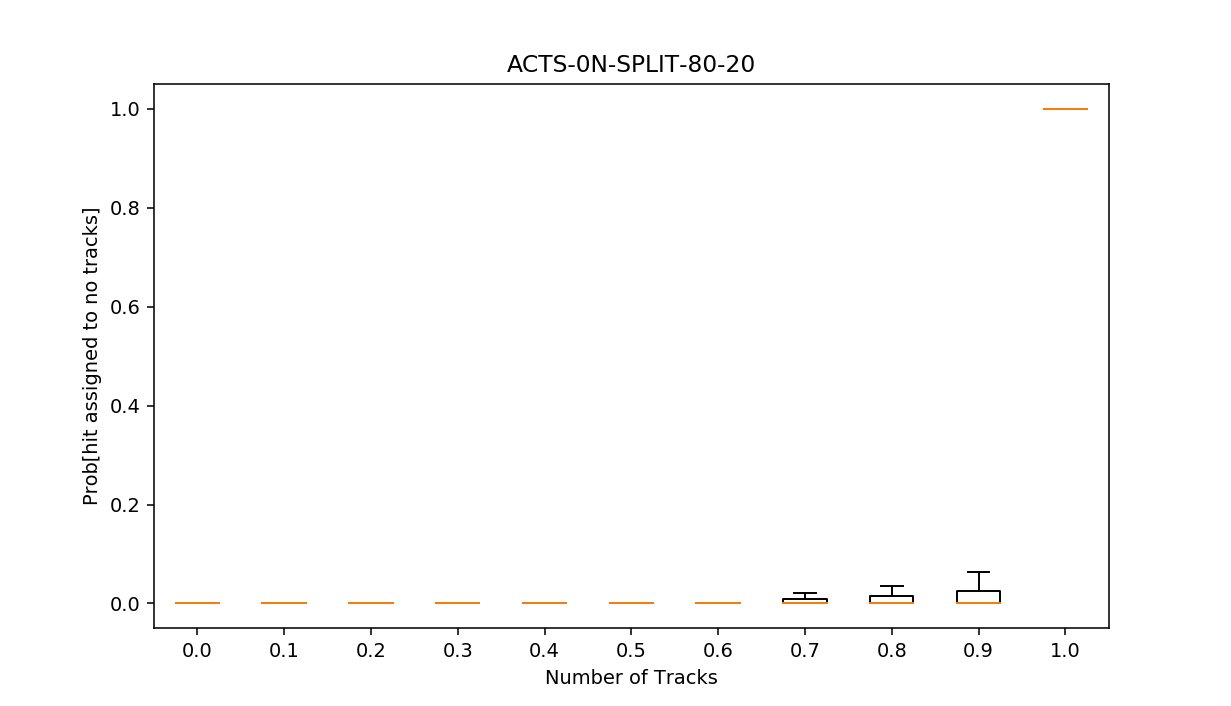

CPU times: user 15min 47s, sys: 336 ms, total: 15min 47s
Wall time: 15min 47s


In [13]:
%%time
thresholds = [i / 10 for i in range(11)]
threshold_metrics = [[metrics.threshold_metrics(test[i], guesses[i], n, order)
                      for i in range(len(guesses))] for n in thresholds]
boxes_correct   = [[m[0] for m in metric] for metric in threshold_metrics]
boxes_incorrect = [[m[1] for m in metric] for metric in threshold_metrics]
boxes_multi     = [[m[2] for m in metric] for metric in threshold_metrics]
boxes_none      = [[m[3] for m in metric] for metric in threshold_metrics]
visuals.boxplot(
    boxes_correct, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to correct track]", xticks=thresholds)
visuals.boxplot(
    boxes_incorrect, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to an incorrect track]", xticks=thresholds)
visuals.boxplot(
    boxes_multi, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to multiple tracks]", xticks=thresholds)
visuals.boxplot(
    boxes_none, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to no tracks]", xticks=thresholds)

In [14]:
bad_tracks = []
for i in range(len(test)):
    if ext.extract_output(test[i], order)[0, 0] == 1:
        bad_tracks.append(test[i])
bad_guesses = model.predict(ext.extract_input(bad_tracks, order))
print(metrics.percent_of_hits_assigned_correctly(bad_tracks, bad_guesses, order))

0.977421083773


In [24]:
print(min([event["momentum"].min() for event in test]))
print(max([event["momentum"].max() for event in test]))

1.00123
100.446


In [25]:
%%time
momentums = [1 + 1/8, 1 + 1/4, 1 + 1/2, 2, 4, 8, 16, 32, 64, 128]
momentums, momentum_acc = metrics.accuracy_vs_momentum(test, guesses, order, momentums)

CPU times: user 3min 58s, sys: 108 ms, total: 3min 58s
Wall time: 3min 58s


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

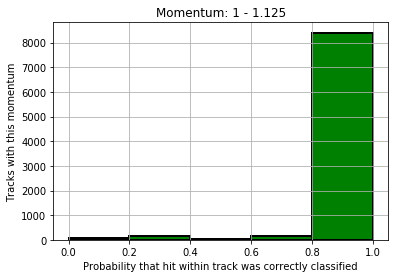

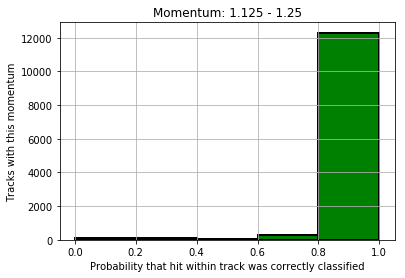

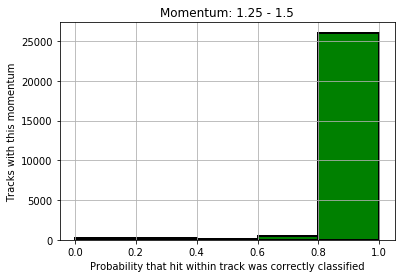

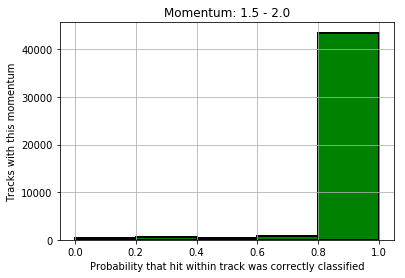

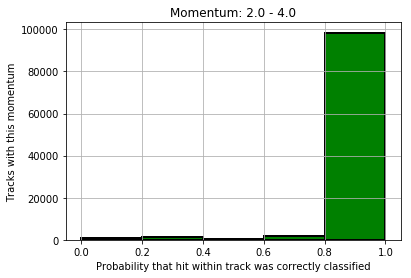

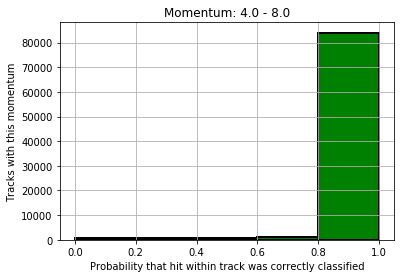

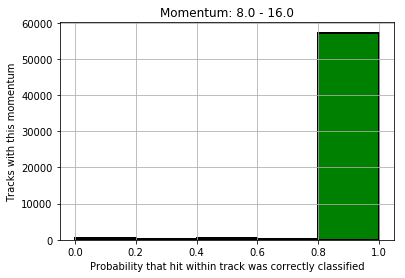

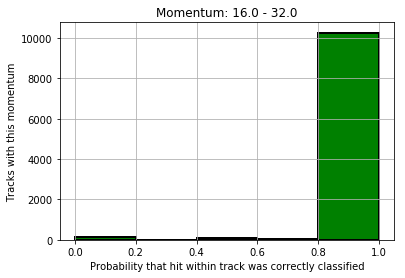

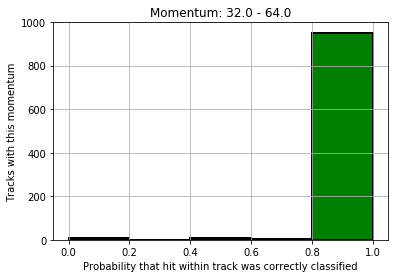

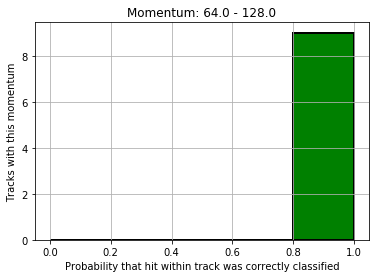

In [28]:
for i, momentum in enumerate(momentums):
    accuracy = momentum_acc[i]
    if accuracy:
        plt.hist(accuracy, bins=5, range=(0, 1), align="mid", edgecolor='black', linewidth=2, color='green')
        plt.title("Momentum: {0} - {1}".format(momentums[i-1] if i > 0 else 1, momentum))
        plt.xlabel("Probability that hit within track was correctly classified")
        plt.ylabel("Tracks with this momentum")
        plt.grid(True)
        plt.show()

<IPython.core.display.Javascript object>


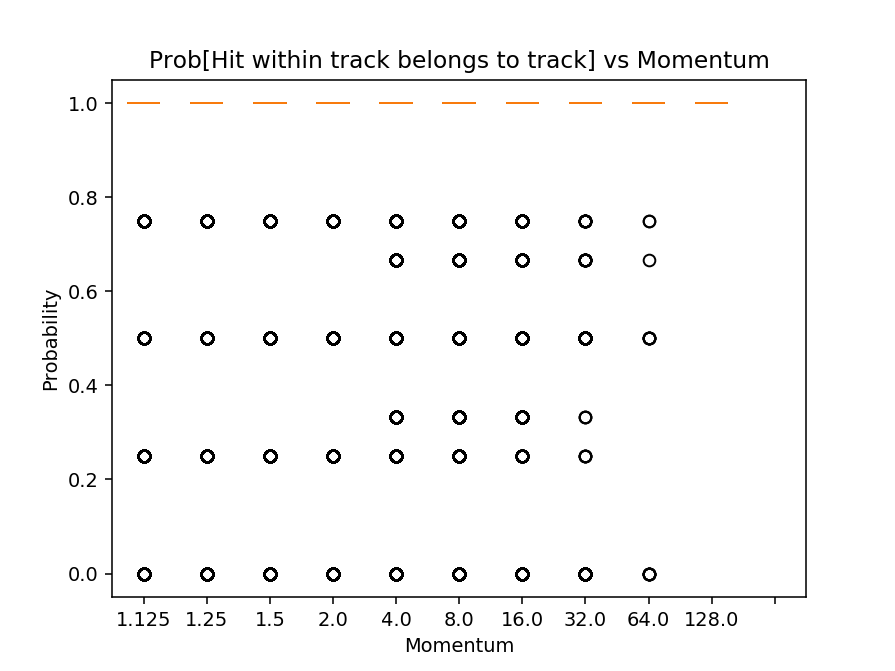

In [29]:
%matplotlib notebook
visuals.boxplot(
    data   = momentum_acc.tolist(),
    fliers = True,  # The little dots in the plot are outliers.
    ylabel = "Probability",
    xlabel = "Momentum",
    title  = "Prob[Hit within track belongs to track] vs Momentum",
    xticks = momentums
)

<IPython.core.display.Javascript object>


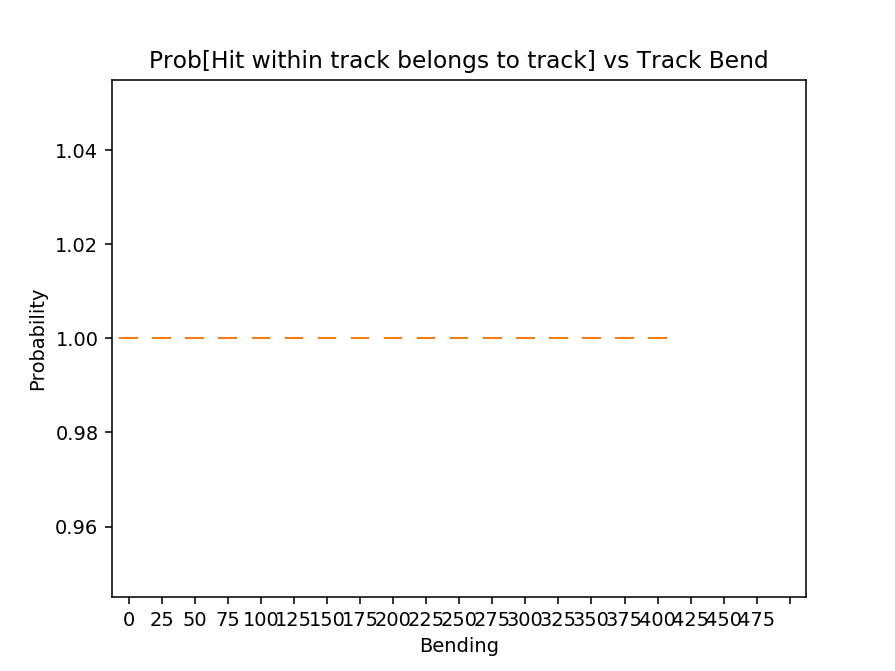

CPU times: user 14min 6s, sys: 780 ms, total: 14min 6s
Wall time: 14min 6s


In [30]:
%%time
bend_amounts = [i for i in range(0, 500, 25)]
bends, acc = metrics.accuracy_vs_bend(test, guesses, order, bend_amounts)
visuals.boxplot(
    data   = acc.tolist(),
    fliers = False,
    ylabel = "Probability",
    xlabel = "Bending",
    title  = "Prob[Hit within track belongs to track] vs Track Bend",
    xticks = bends
)